In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
# path
train_path = 'D:/test2/ETT_v3/Fold5/train/'
train_annot_path = 'D:/test2/ETT_v3/Fold5/trainannot/'
val_path = 'D:/test2/ETT_v3/Fold5/val/'
val_annot_path = 'D:/test2/ETT_v3/Fold5/valannot/'
test_path = 'D:/test2/ETT_v3/Fold5/test/'
test_annot_path = 'D:/test2/ETT_v3/Fold5/testannot/'

In [17]:
def fcn_8s(input_shape=(256, 256, 3), num_classes=2):
    # 載入VGG16模型
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # 取得特定的VGG層
    block4_pool = base_model.get_layer('block4_pool').output
    block3_pool = base_model.get_layer('block3_pool').output

    # 最後一層卷積層的輸出
    x = base_model.output
    
    # 擴張卷積層
    x = Conv2D(4096, (7, 7), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(4096, (1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # 第一個轉置卷積層
    x = Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same')(x)
    x = Add()([x, block4_pool])

    # 第二個轉置卷積層
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = Add()([x, block3_pool])

    # 最後一個轉置卷積層，恢復到原始圖像尺寸
    x = Conv2DTranspose(num_classes, (16, 16), strides=(8, 8), padding='same')(x)

    # 輸出層，使用softmax進行多類別分類
    output = Activation('softmax')(x)

    # 建立模型
    model = Model(inputs=base_model.input, outputs=output)
    
    return model


In [18]:
def load_and_preprocess_image(image_path, mask_path, target_size=(256, 256)):
    # 讀取圖像和對應的標籤
    image = load_img(image_path, target_size=target_size)
    mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
    
    # 轉換為數組並進行正規化
    image = img_to_array(image) / 255.0
    mask = img_to_array(mask) // 255  # 假設標籤圖像是黑白的，每個像素255表示標籤1
    
    return image, mask

def prepare_dataset(path, annot_path, batch_size):
    # 獲取所有圖像的路徑
    image_filenames = os.listdir(path)
    mask_filenames = os.listdir(annot_path)
    
    # 確保排序後的圖像和標籤對應
    image_filenames.sort()
    mask_filenames.sort()
    
    image_paths = [os.path.join(path, fname) for fname in image_filenames]
    mask_paths = [os.path.join(annot_path, fname) for fname in mask_filenames]
    
    # 載入和前處理所有圖像和標籤
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img, mask = load_and_preprocess_image(img_path, mask_path)
        images.append(img)
        masks.append(mask)
    
    # 將列表轉換為Numpy數組
    images = np.array(images)
    masks = np.array(masks)
    
    # 建立資料集
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size)
    return dataset

# 訓練和驗證資料集
train_dataset = prepare_dataset(train_path, train_annot_path, batch_size=8)
val_dataset = prepare_dataset(val_path, val_annot_path, batch_size=8)
test_dataset = prepare_dataset(test_path, test_annot_path, batch_size=8)

In [19]:
model = fcn_8s()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    verbose=1,          
    restore_best_weights=True  
)


# 設定訓練的epochs數
epochs = 25

# 訓練資料
history = model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]  
)

# 測試資料
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

Epoch 1/25
36/36 [==============================] - 292s 8s/step - loss: 1.3424 - accuracy: 0.9501 - val_loss: 21.4623 - val_accuracy: 0.8740
Epoch 2/25
36/36 [==============================] - 284s 8s/step - loss: 0.6038 - accuracy: 0.9835 - val_loss: 0.1485 - val_accuracy: 0.9932
Epoch 3/25
36/36 [==============================] - 284s 8s/step - loss: 0.0528 - accuracy: 0.9872 - val_loss: 0.0330 - val_accuracy: 0.9951
Epoch 4/25
36/36 [==============================] - 282s 8s/step - loss: 0.0278 - accuracy: 0.9900 - val_loss: 0.0201 - val_accuracy: 0.9951
Epoch 5/25
36/36 [==============================] - 283s 8s/step - loss: 0.0272 - accuracy: 0.9901 - val_loss: 0.0167 - val_accuracy: 0.9949
Epoch 6/25
36/36 [==============================] - 305s 8s/step - loss: 0.0245 - accuracy: 0.9904 - val_loss: 0.0155 - val_accuracy: 0.9951
Epoch 7/25
36/36 [==============================] - 284s 8s/step - loss: 0.0240 - accuracy: 0.9906 - val_loss: 0.0274 - val_accuracy: 0.9898
Epoch 8/25
3

In [21]:
# Visualize some predictions
def plot_predictions(images, masks, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        plt.show()

In [22]:
def calculate_iou(y_true, y_pred, num_classes):
    # y_pred 需要透過 argmax 獲取最有可能的類別
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    iou_calculator = MeanIoU(num_classes=num_classes)
    iou_calculator.update_state(y_true, y_pred)
    return iou_calculator.result().numpy()

In [23]:
def indicator_within_range(y_true, y_pred, threshold, P):
    threshold_pixels = tf.cast(P * threshold, tf.int32)  # 轉換成整數
    return tf.cast(tf.abs(y_true - y_pred) <= threshold_pixels, tf.float32)

def accuracy_within_0_5_cm(y_true, y_pred, P):
    # 確保 y_true 和 y_pred 都是 tf.int32 類型
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    K = tf.size(y_true, out_type=tf.int32)  # tf.size 的 out_type 也設定為 tf.int32
    indicator_values = indicator_within_range(y_true, y_pred, 0.5, P)
    return tf.reduce_sum(indicator_values) / tf.cast(K, tf.float32) * 100

def accuracy_within_1_cm(y_true, y_pred, P):
    # 確保 y_true 和 y_pred 都是 tf.int32 類型
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    K = tf.size(y_true, out_type=tf.int32)  # tf.size 的 out_type 也設定為 tf.int32
    indicator_values = indicator_within_range(y_true, y_pred, 1.0, P)
    return tf.reduce_sum(indicator_values) / tf.cast(K, tf.float32) * 100

In [24]:
def check_predictions(y_true, y_pred, num_classes):
    if tf.reduce_any(y_pred >= num_classes) or tf.reduce_any(y_pred < 0):
        raise ValueError(f"`y_pred` has invalid values. All elements must be in range [0, {num_classes-1}]")
    if tf.reduce_any(y_true >= num_classes) or tf.reduce_any(y_true < 0):
        raise ValueError(f"`y_true` has invalid values. All elements must be in range [0, {num_classes-1}]")

In [25]:
# 修改evaluate_model函數以包含精確度計算
def evaluate_model(model, dataset, num_classes, P):
    total_iou = 0
    accuracy_0_5_cm_total = 0
    accuracy_1_0_cm_total = 0
    count = 0
    for images, masks in dataset:
        predictions = model.predict(images)
        y_pred = tf.argmax(predictions, axis=-1)
        y_true = tf.cast(tf.squeeze(masks), tf.int32)


        if not tf.reduce_all(tf.less(y_true, num_classes)):
            print("y_true contains values outside [0, num_classes-1]")
        if not tf.reduce_all(tf.less(y_pred, num_classes)):
            print("y_pred contains values outside [0, num_classes-1]")

        # 檢查預測值是否有效
        check_predictions(y_true, y_pred, num_classes)
        
        iou_calculator = MeanIoU(num_classes=num_classes)
        iou_calculator.update_state(y_true, y_pred)
        iou_score = iou_calculator.result().numpy()
        total_iou += iou_score
        
        # 計算精度
        accuracy_0_5_cm_total += accuracy_within_0_5_cm(y_true, y_pred, P)
        accuracy_1_0_cm_total += accuracy_within_1_cm(y_true, y_pred, P)
        
        count += 1

    avg_iou = total_iou / count if count else 0
    avg_accuracy_0_5_cm = accuracy_0_5_cm_total / count if count else 0
    avg_accuracy_1_0_cm = accuracy_1_0_cm_total / count if count else 0
    
    return avg_iou, avg_accuracy_0_5_cm, avg_accuracy_1_0_cm

# 設定像素到公分的轉換比例
P = 72  # 每公分72像素

# 在訓練資料集上評估模型
train_iou, train_accuracy_0_5_cm, train_accuracy_1_0_cm = evaluate_model(model, train_dataset, num_classes=2, P=P)
print(f"Training Data: Average IOU: {train_iou}")
print(f"Training Data: Average Accuracy within 0.5 cm: {train_accuracy_0_5_cm}")
print(f"Training Data: Average Accuracy within 1.0 cm: {train_accuracy_1_0_cm}")

1/1 [==============================] - 1s 1s/step
Training Data: Average IOU: 0.8033203283945719
Training Data: Average Accuracy within 0.5 cm: 100.0
Training Data: Average Accuracy within 1.0 cm: 100.0


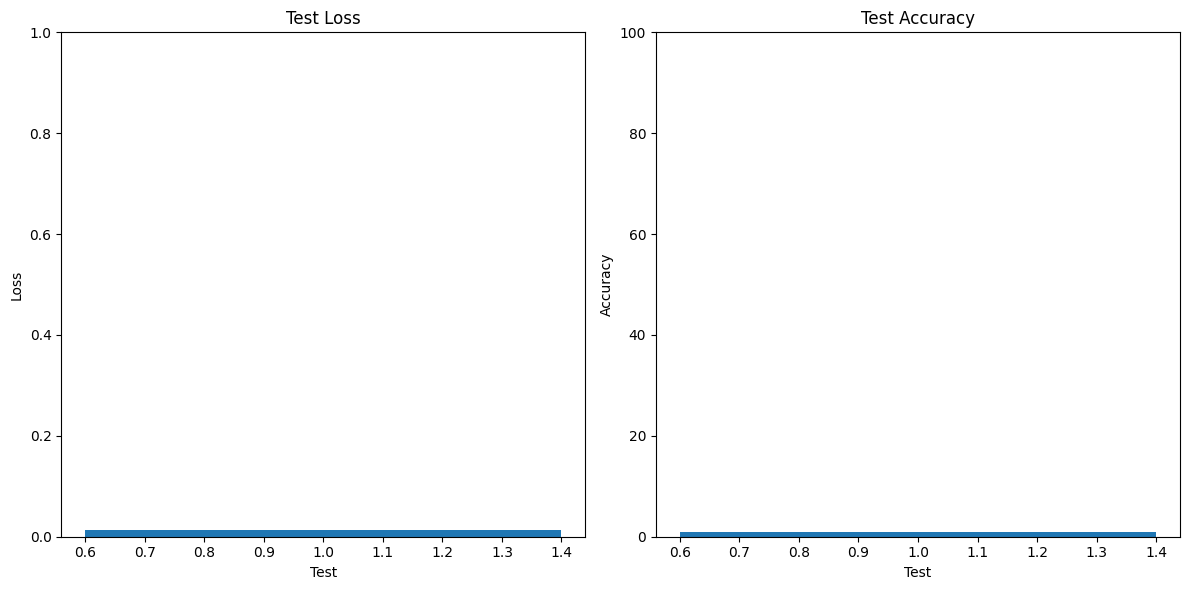

In [26]:
def plot_test_results(test_loss, test_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].bar(1, test_loss)
    ax[0].set_title('Test Loss')
    ax[0].set_xlabel('Test')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim([0, max(test_loss * 1.1, 1)])

    ax[1].bar(1, test_accuracy)
    ax[1].set_title('Test Accuracy')
    ax[1].set_xlabel('Test')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim([0, 100])

    plt.tight_layout()
    plt.show()

plot_test_results(test_loss, test_accuracy)

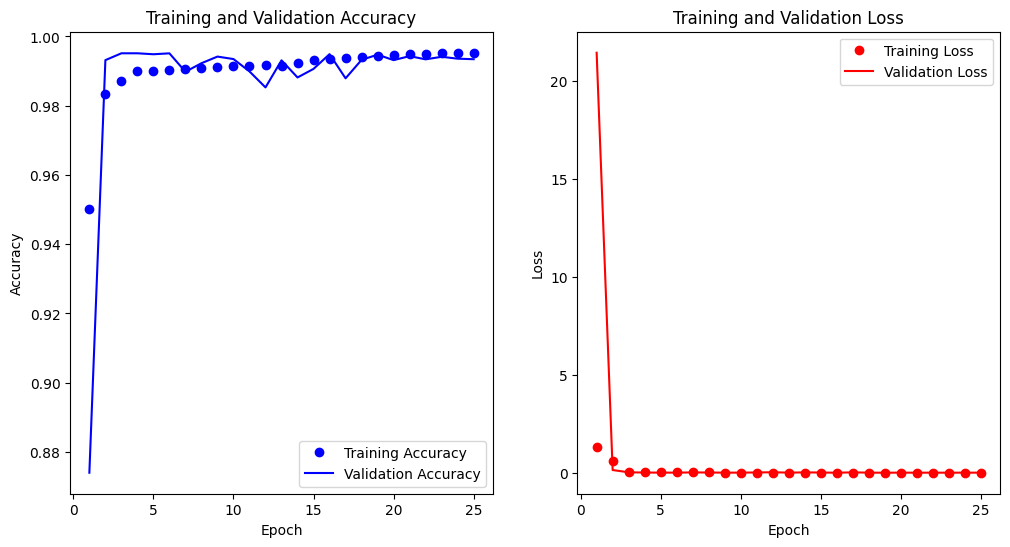

1/1 [==============================] - 1s 1s/step


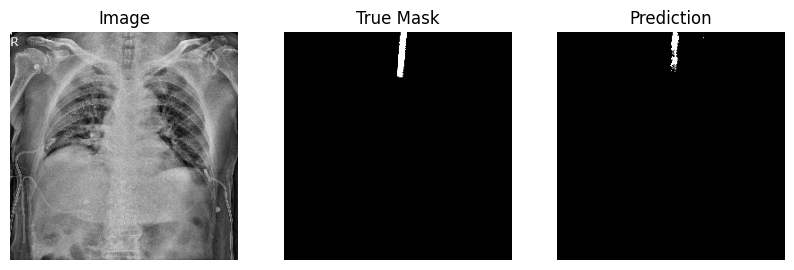

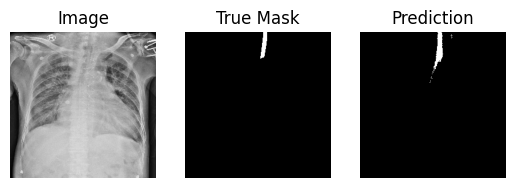

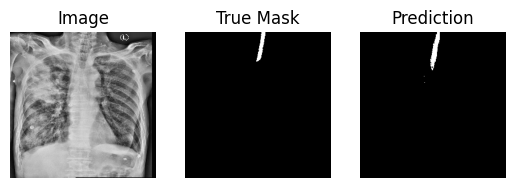

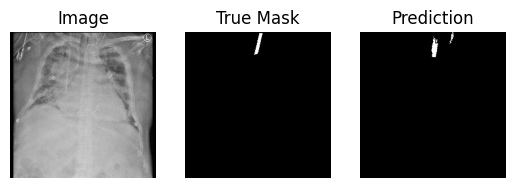

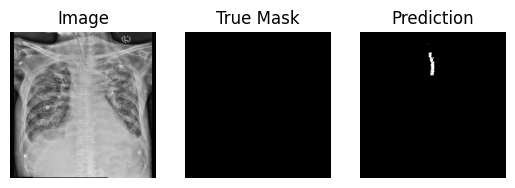

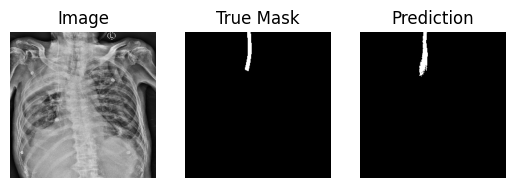

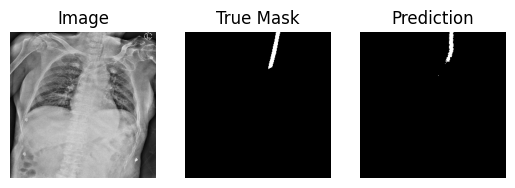

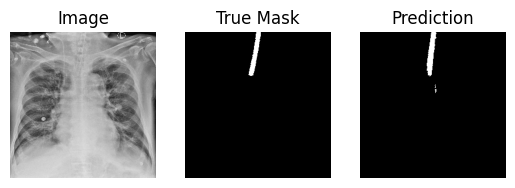

In [27]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)
for images, masks in train_dataset.take(1):
    predictions = model.predict(images)
    predictions = tf.argmax(predictions, axis=-1)
    predictions = predictions[..., tf.newaxis]
    plot_predictions(images.numpy(), masks.numpy(), predictions.numpy()) 

Test Loss: 0.01362858060747385
Test Accuracy: 99.47172999382019%


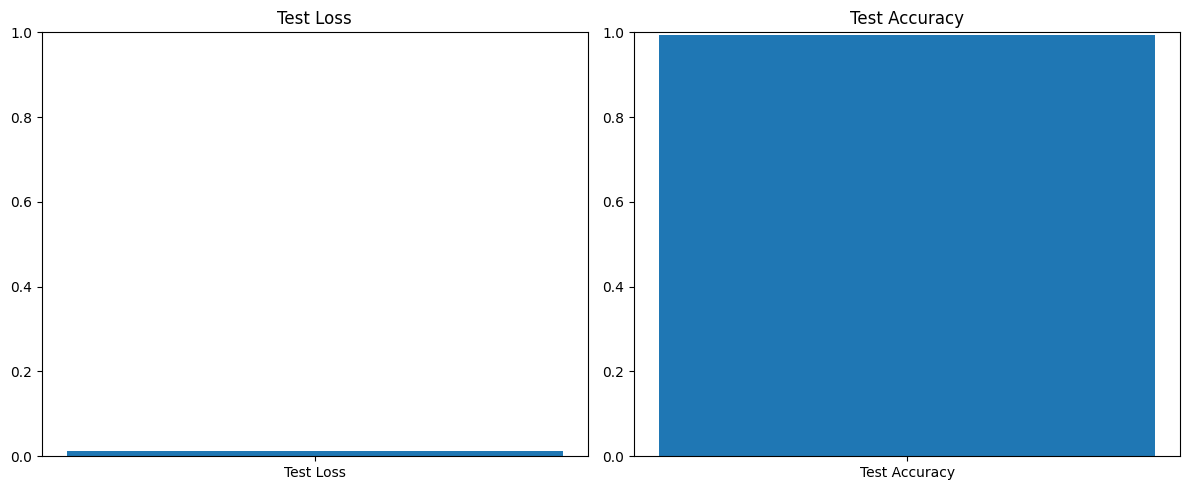

In [28]:
def display_test_results(test_loss, test_accuracy):
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy * 100}%")

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].bar(['Test Loss'], [test_loss])
    ax[0].set_title('Test Loss')
    ax[0].set_ylim([0, max(test_loss * 1.2, 1)])

    ax[1].bar(['Test Accuracy'], [test_accuracy])
    ax[1].set_title('Test Accuracy')
    ax[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()


display_test_results(test_loss, test_accuracy)